In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from pathlib import Path
from ultralytics import YOLO
import warnings
warnings.filterwarnings('ignore')

print(" All imports successful")

 All imports successful


In [9]:
#model paths
CLASSIFIER_PATH = r"C:\Final Project 3\best_bone_fracture_model.pth"
DETECTOR_PATH = r"C:\Final project 2\backend\runs_combined\yolo11l_unified_2class2\weights\best.pt"

#input and output paths
INPUT_IMAGE = r"C:\Final project 2\backend\datasets\Combined_Set\images\train\fracture_bfd1_train_00985.jpg"  # UPDATE THIS!
OUTPUT_DIR = r"C:\Final Project 3\pipeline_results"

#parameters
CONFIDENCE_THRESHOLD = 0.5  # Classifier confidence threshold
YOLO_CONFIDENCE = 0.25      # YOLO detection confidence
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Class names
CLASS_NAMES = ['Not Fractured', 'Fractured']

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Device: {DEVICE}")
print(f"Classifier: {CLASSIFIER_PATH}")
print(f"Detector: {DETECTOR_PATH}")
print(f"Output Directory: {OUTPUT_DIR}")

Device: cuda
Classifier: C:\Final Project 3\best_bone_fracture_model.pth
Detector: C:\Final project 2\backend\runs_combined\yolo11l_unified_2class2\weights\best.pt
Output Directory: C:\Final Project 3\pipeline_results


In [10]:

# ResNet50 Classifier Model

class BoneFractureClassifier(nn.Module):
    #ResNet50-based binary classifier for fracture detection
    def __init__(self):
        super(BoneFractureClassifier, self).__init__()
        self.resnet = models.resnet50(pretrained=False)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )
    
    def forward(self, x):
        return self.resnet(x)


# GradCAM Implementation

class GradCAM:
    #Gradient-weighted Class Activation Mapping
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_tensor, target_class=None):
        self.model.eval()
        output = self.model(input_tensor)
        
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        self.model.zero_grad()
        output[0, target_class].backward()
        
        gradients = self.gradients[0]
        activations = self.activations[0]
        weights = gradients.mean(dim=(1, 2))
        
        # Create cam on same device
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=activations.device)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        
        return cam.cpu().numpy(), target_class

print(" Model classes defined")

 Model classes defined


In [11]:

print("LOADING MODELS")



# Load ResNet50 Classifier

print("\n[1/2] Loading ResNet50 Classifier...")
classifier = BoneFractureClassifier()
checkpoint = torch.load(CLASSIFIER_PATH, map_location=DEVICE)

if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    classifier.load_state_dict(checkpoint['model_state_dict'])
    if 'best_acc' in checkpoint:
        print(f"    Classifier loaded | Accuracy: {checkpoint['best_acc']:.2f}%")
    else:
        print("    Classifier loaded")
else:
    classifier.load_state_dict(checkpoint)
    print("    Classifier loaded")

classifier = classifier.to(DEVICE)
classifier.eval()

# Initialize GradCAM
gradcam = GradCAM(classifier, classifier.resnet.layer4[-1])
print("   GradCAM initialized")


# Load YOLOv11 Detector

print("\n[2/2] Loading YOLOv11 Detector...")
detector = YOLO(DETECTOR_PATH)
print("    Detector loaded")


print("ALL MODELS LOADED SUCCESSFULLY")


LOADING MODELS

[1/2] Loading ResNet50 Classifier...
    Classifier loaded | Accuracy: 91.19%
   GradCAM initialized

[2/2] Loading YOLOv11 Detector...
    Detector loaded
ALL MODELS LOADED SUCCESSFULLY


In [12]:
def apply_gradcam(original_image, cam):
    #Apply GradCAM heatmap to image
    org_im_np = np.array(original_image)
    height, width = org_im_np.shape[:2]
    
    # Resize CAM
    cam_resized = cv2.resize(cam, (width, height))
    heatmap = np.uint8(255 * cam_resized)
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Create overlay
    overlay = heatmap_colored * 0.4 + org_im_np * 0.6
    overlay = np.uint8(overlay)
    
    return heatmap_colored, overlay

def classify_image(image_path, classifier, gradcam, device):
    #Classify image using ResNet50 and generate GradCAM
    # Preprocess
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load image
    original_image = Image.open(image_path).convert('RGB')
    input_tensor = transform(original_image).unsqueeze(0).to(device)
    
    # Classify
    with torch.no_grad():
        output = classifier(input_tensor)
        probabilities = F.softmax(output, dim=1)
        pred_class = output.argmax(dim=1).item()
        confidence = probabilities[0, pred_class].item()
    
    # Generate GradCAM
    cam, _ = gradcam.generate_cam(input_tensor, pred_class)
    
    return {
        'class': pred_class,
        'class_name': CLASS_NAMES[pred_class],
        'confidence': confidence,
        'probabilities': probabilities[0].cpu().numpy(),
        'cam': cam,
        'original_image': original_image
    }

def detect_fractures(image_path, detector, confidence=0.25):
    #Detect fractures using YOLOv11
    results = detector(image_path, conf=confidence, verbose=False)
    return results[0]

def visualize_detections(image, results):
    #Draw bounding boxes on image
    img_with_boxes = image.copy()
    
    if results.boxes is not None and len(results.boxes) > 0:
        for box in results.boxes:
            # Get box coordinates
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())
            
            # Get class name
            class_name = results.names[cls] if hasattr(results, 'names') else f'Class {cls}'
            
            # Draw box
            cv2.rectangle(img_with_boxes, (int(x1), int(y1)), (int(x2), int(y2)), 
                         (0, 255, 0), 3)
            
            # Add label
            label = f'{class_name}: {conf:.2f}'
            cv2.putText(img_with_boxes, label, (int(x1), int(y1)-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    return img_with_boxes

print(" Helper functions defined")

 Helper functions defined


In [13]:
def fracture_detection_pipeline(image_path, classifier, detector, gradcam, device,
                               confidence_threshold=0.5, yolo_confidence=0.25,
                               save_results=True, output_dir=None, show_plots=True):
    
   
    print("FRACTURE DETECTION PIPELINE")
    
    print(f"Input: {os.path.basename(image_path)}")
    
    # stage 1- classification
    print("\n[STAGE 1] Running Classifier...")
    classification_result = classify_image(image_path, classifier, gradcam, device)
    
    pred_class = classification_result['class']
    pred_name = classification_result['class_name']
    confidence = classification_result['confidence']
    cam = classification_result['cam']
    original_image = classification_result['original_image']
    
    print(f"   Prediction: {pred_name}")
    print(f"   Confidence: {confidence*100:.2f}%")
    print(f"   Probabilities: Not Fractured={classification_result['probabilities'][0]*100:.1f}%, "
          f"Fractured={classification_result['probabilities'][1]*100:.1f}%")
    
    # Generate GradCAM visualization
    heatmap, overlay = apply_gradcam(original_image, cam)
    
    
    # stage 2- localization
    detection_result = None
    img_with_boxes = None
    
    if pred_class == 1:  # Fractured
        if confidence >= confidence_threshold:
            print(f"\n[STAGE 2] Fracture Detected! Running Detector...")
            detection_result = detect_fractures(image_path, detector, yolo_confidence)
            
            # Count detections
            num_detections = len(detection_result.boxes) if detection_result.boxes is not None else 0
            print(f"   Detections: {num_detections} fracture(s) localized")
            
            # Draw boxes
            img_np = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2BGR)
            img_with_boxes = visualize_detections(img_np, detection_result)
            img_with_boxes = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
        else:
            print(f"\n[STAGE 2] Skipped - Confidence ({confidence*100:.1f}%) below threshold ({confidence_threshold*100:.1f}%)")
    else:
        print(f"\n[STAGE 2] Skipped - No fracture detected")
    
    # visualization
    if show_plots:
        if img_with_boxes is not None:
            # 4-panel visualization (with detections)
            fig, axes = plt.subplots(2, 2, figsize=(16, 16))
            
            axes[0, 0].imshow(original_image)
            axes[0, 0].set_title('Original Image', fontsize=14, fontweight='bold')
            axes[0, 0].axis('off')
            
            axes[0, 1].imshow(heatmap)
            axes[0, 1].set_title('GradCAM Heatmap', fontsize=14, fontweight='bold')
            axes[0, 1].axis('off')
            
            axes[1, 0].imshow(overlay)
            axes[1, 0].set_title(f'GradCAM Overlay\n{pred_name} ({confidence*100:.1f}%)', 
                                fontsize=14, fontweight='bold')
            axes[1, 0].axis('off')
            
            axes[1, 1].imshow(img_with_boxes)
            axes[1, 1].set_title(f'Fracture Detection\n{num_detections} detection(s)', 
                                fontsize=14, fontweight='bold')
            axes[1, 1].axis('off')
        else:
            # 3-panel visualization (no detections)
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            
            axes[0].imshow(original_image)
            axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
            axes[0].axis('off')
            
            axes[1].imshow(heatmap)
            axes[1].set_title('GradCAM Heatmap', fontsize=14, fontweight='bold')
            axes[1].axis('off')
            
            axes[2].imshow(overlay)
            axes[2].set_title(f'GradCAM Overlay\n{pred_name} ({confidence*100:.1f}%)', 
                            fontsize=14, fontweight='bold')
            axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # save results
    if save_results and output_dir:
        filename = os.path.splitext(os.path.basename(image_path))[0]
        
        # Save GradCAM overlay
        overlay_path = os.path.join(output_dir, f"{filename}_gradcam.jpg")
        Image.fromarray(overlay).save(overlay_path)
        
        # Save detection result if available
        if img_with_boxes is not None:
            detection_path = os.path.join(output_dir, f"{filename}_detections.jpg")
            Image.fromarray(img_with_boxes).save(detection_path)
            print(f"\n✓ Results saved:")
            print(f"   - GradCAM: {overlay_path}")
            print(f"   - Detections: {detection_path}")
        else:
            print(f"\n GradCAM saved: {overlay_path}")
    
    # results
    
    print("PIPELINE COMPLETE")
    
    
    return {
        'classification': classification_result,
        'detection': detection_result,
        'images': {
            'original': original_image,
            'gradcam_heatmap': heatmap,
            'gradcam_overlay': overlay,
            'detections': img_with_boxes
        }
    }

print(" Pipeline function defined")

 Pipeline function defined


FRACTURE DETECTION PIPELINE
Input: fracture_bfd1_train_00985.jpg

[STAGE 1] Running Classifier...
   Prediction: Fractured
   Confidence: 100.00%
   Probabilities: Not Fractured=0.0%, Fractured=100.0%

[STAGE 2] Fracture Detected! Running Detector...
   Detections: 2 fracture(s) localized


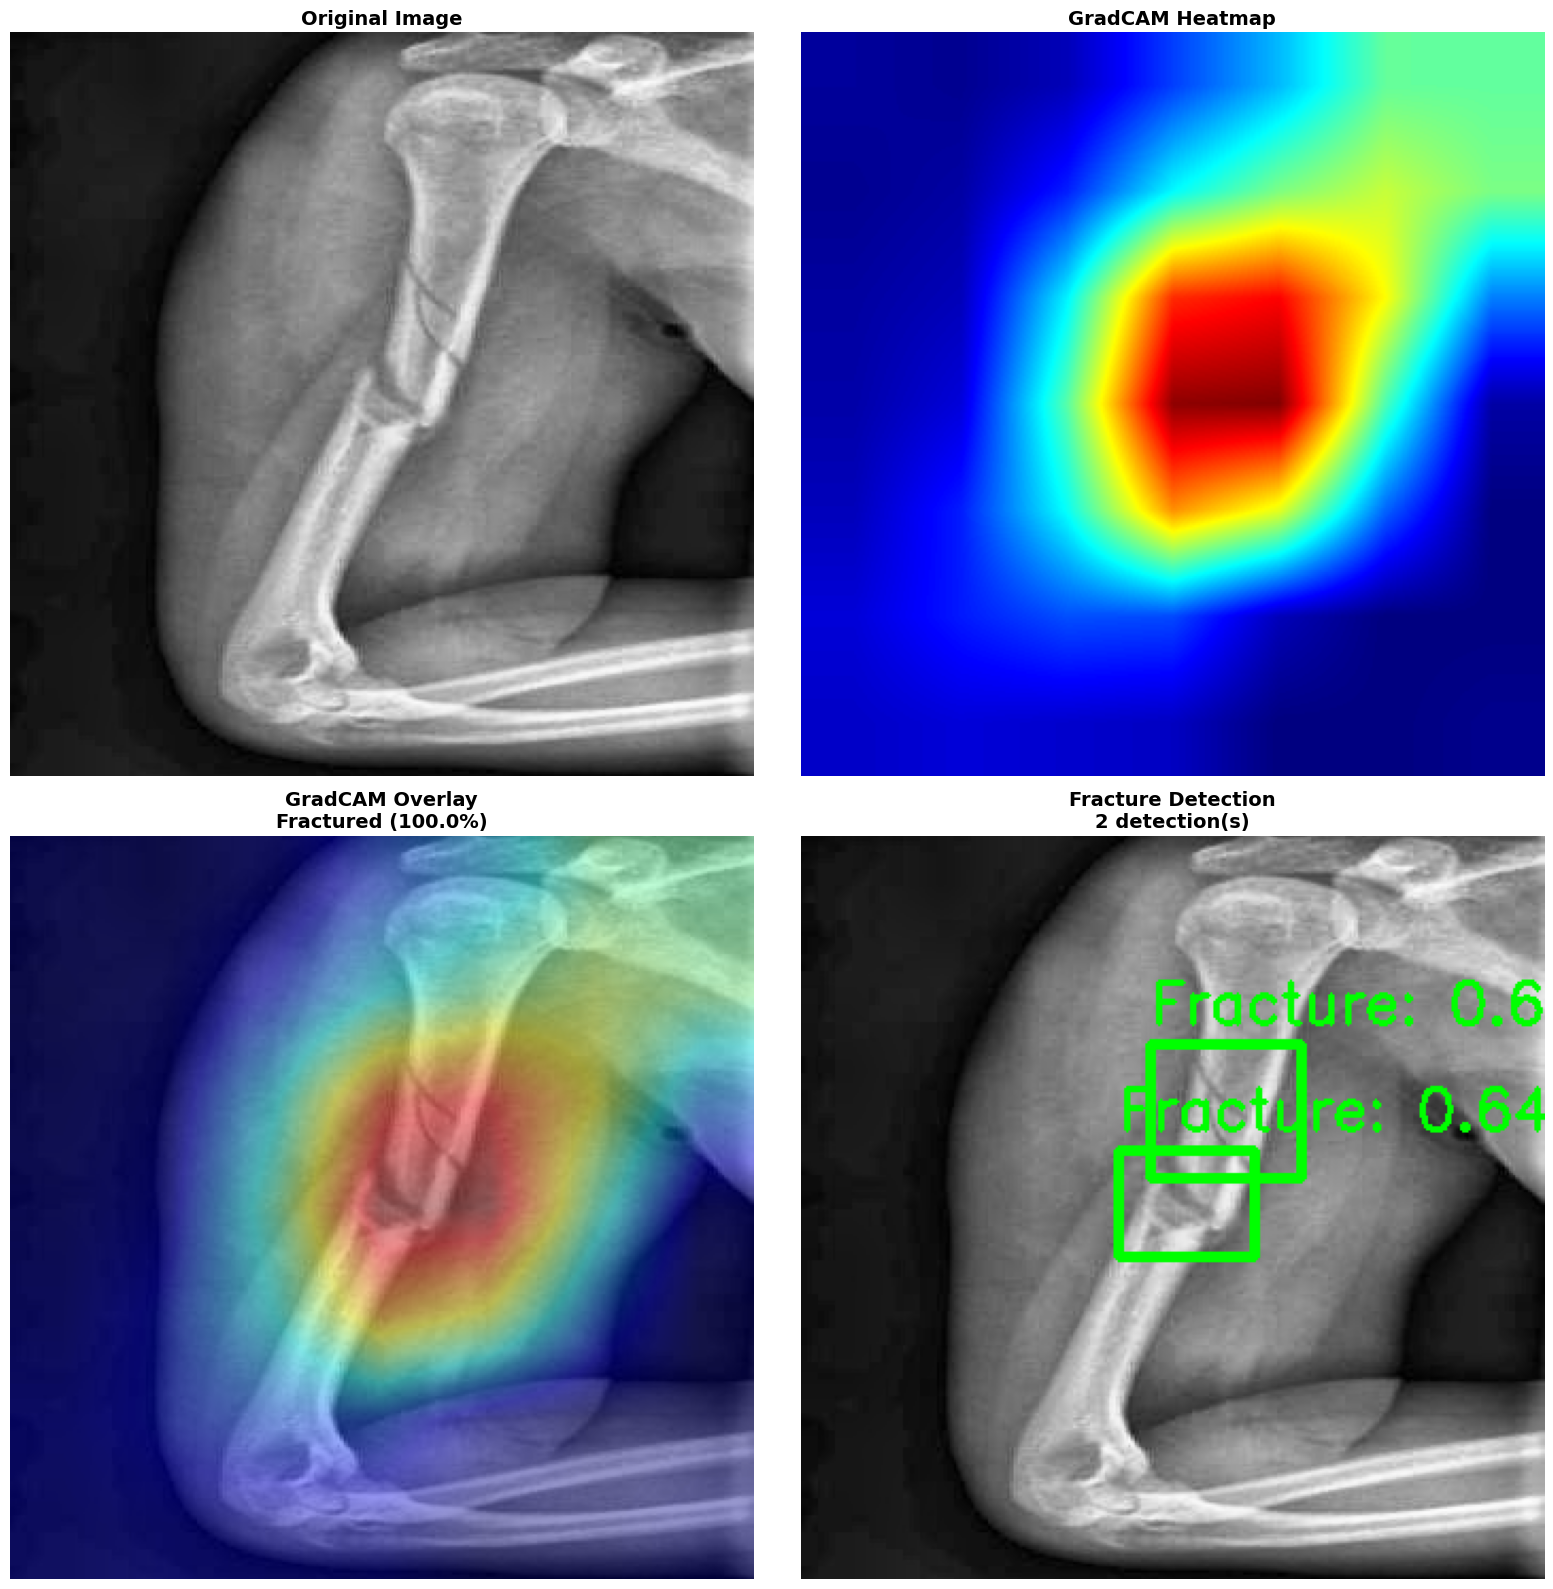


✓ Results saved:
   - GradCAM: C:\Final Project 3\pipeline_results\fracture_bfd1_train_00985_gradcam.jpg
   - Detections: C:\Final Project 3\pipeline_results\fracture_bfd1_train_00985_detections.jpg
PIPELINE COMPLETE


In [14]:
# Run the pipeline
results = fracture_detection_pipeline(
    image_path=INPUT_IMAGE,
    classifier=classifier,
    detector=detector,
    gradcam=gradcam,
    device=DEVICE,
    confidence_threshold=CONFIDENCE_THRESHOLD,
    yolo_confidence=YOLO_CONFIDENCE,
    save_results=True,
    output_dir=OUTPUT_DIR,
    show_plots=True
)